In [46]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

from sklearn.metrics import classification_report, confusion_matrix

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

/tmp/ipykernel_10725/204911122.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [47]:
df = pd.read_csv("sentiment-emotion-labelled_Dell_tweets.csv")
data = df[['Text','sentiment']]
df=data
df

,Text,sentiment
0,@Logitech @apple @Google @Microsoft @Dell @Len...,neutral
1,@MK_habit_addict @official_stier @MortalKombat...,neutral
2,"As @CRN celebrates its 40th anniversary, Bob F...",positive
3,@dell your customer service is horrible especi...,negative
4,@zacokalo @Dell @DellCares @Dell give the man ...,neutral
...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,negative
24966,@kite_real @GamersNexus @Dell I didn't really ...,positive
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,neutral
24968,@bravadogaming @thewolfpena @Alienware @intel ...,neutral


In [48]:
df = df.rename(columns={'Text': 'text'})

In [49]:
#dropping duplicate tweets

df.duplicated().sum()
df = df[~df.duplicated()]

In [50]:
df.sentiment.value_counts()

negative    10483
positive     7167
neutral      6989
Name: sentiment, dtype: int64

In [51]:
# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)


# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_all_entities(tweet)
    tweet = remove_short_words(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = ' '.join
    
def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else: #positive
        return 2

In [52]:
df['text_clean'] = df['text'].apply(strip_all_entities)
df['sentiment'] = df['sentiment'].apply(label_map)

In [53]:
df

,text,sentiment,text_clean
0,@Logitech @apple @Google @Microsoft @Dell @Len...,1,whatif qwerty modified programmers things like...
1,@MK_habit_addict @official_stier @MortalKombat...,1,shes getting new laptop one one 23 years old t...
2,"As @CRN celebrates its 40th anniversary, Bob F...",2,ascelebrates 40th anniversarybob faletraandspo...
3,@dell your customer service is horrible especi...,0,customer service horrible especially agent sye...
4,@zacokalo @Dell @DellCares @Dell give the man ...,1,give man paid
...,...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,0,wouldnt even know blow whistle people followin...
24966,@kite_real @GamersNexus @Dell I didn't really ...,2,didnt really leave ethical reasons personal ho...
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,1,hey is27 4k uhd usbc
24968,@bravadogaming @thewolfpena @Alienware @intel ...,1,imma honest never watched dragon ball z imma t...


In [54]:
X = df['text_clean']
y = df['sentiment']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [57]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6708],
       [   1, 4473],
       [   2, 4587]])

In [58]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
        
    return sorted_words, features


In [59]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], 30)

In [60]:
df["text_clean"].iloc[10]

'take delight stakeholders online experience whitepaper technologies apex shows transformation paves path posthybrid cloud era learn team accel bi corporation get started'

In [61]:
tokenized_column[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,   59, 2591, 2325,
        271,   55, 1375,  106,  477,  415,  837, 2592, 1861, 2850,  160,
       1587,   81,   50, 4712, 4334, 2058,    6,  252])

In [62]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [63]:
EMBEDDING_DIM = 200

In [64]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [65]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 29330


In [66]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [67]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (29330, 200)


In [25]:
X = tokenized_column
y = df['sentiment'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [28]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6708],
       [   1, 4473],
       [   2, 4587]])

In [29]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [30]:
BATCH_SIZE = 32

In [31]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [32]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        

In [33]:
NUM_CLASSES = 3 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(29330, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [34]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')


Epoch 1:Validation accuracy increased (0.000000 --> 67.276423).  Saving model ...
	Train_loss : 0.8664 Val_loss : 0.7273
	Train_acc : 57.184% Val_acc : 67.276%
Epoch 2:Validation accuracy increased (67.276423 --> 72.586382).  Saving model ...
	Train_loss : 0.5742 Val_loss : 0.6635
	Train_acc : 76.010% Val_acc : 72.586%
Epoch 3:Validation accuracy increased (72.586382 --> 74.872967).  Saving model ...
	Train_loss : 0.3706 Val_loss : 0.6484
	Train_acc : 85.791% Val_acc : 74.873%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.2397 Val_loss : 0.7289
	Train_acc : 91.311% Val_acc : 74.568%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.1659 Val_loss : 0.8568
	Train_acc : 94.372% Val_acc : 74.416%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.1264 Val_loss : 0.8776
	Train_acc : 95.859% Val_acc : 73.908%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0991 Val_loss : 1.0936
	Train_acc : 96.710% Val_acc : 72.434%
Epoch 8:Validation accurac

In [35]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [36]:
sentiments = ["negative","neutral","positive"]

In [39]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    negative       0.76      0.88      0.82      2097
     neutral       0.66      0.52      0.58      1398
    positive       0.73      0.72      0.72      1433

    accuracy                           0.73      4928
   macro avg       0.72      0.71      0.71      4928
weighted avg       0.72      0.73      0.72      4928



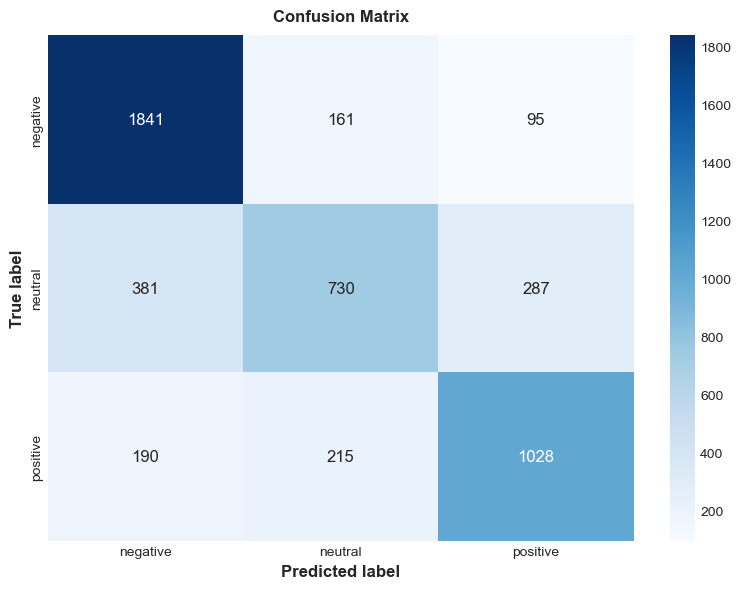

In [76]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_list, y_pred_list)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 12},xticklabels=sentiments, yticklabels=sentiments)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.savefig('dell_sentiment.jpg')
plt.show()


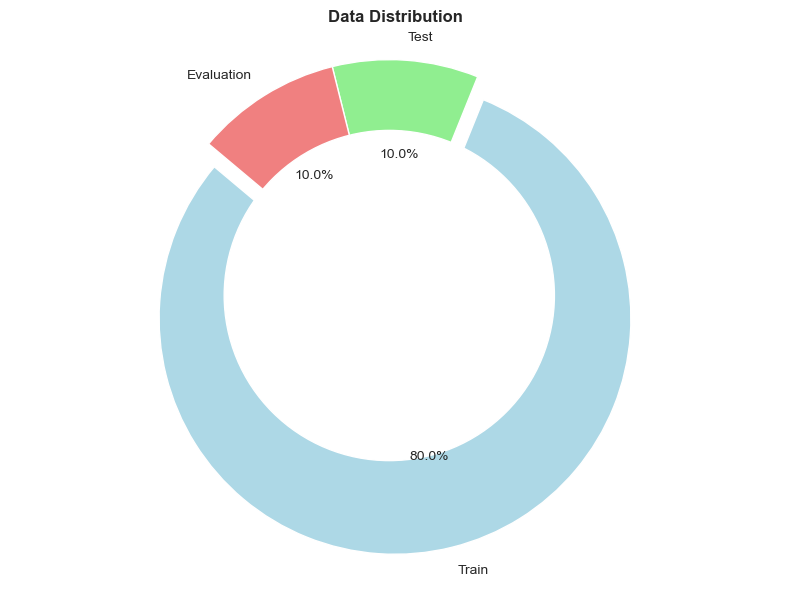

In [70]:
import matplotlib.pyplot as plt

# Define the sizes of train, test, and evaluation sets
train_size = 80
test_size = 10
eval_size = 10

sizes = [train_size, test_size, eval_size]
labels = ['Train', 'Test', 'Evaluation']
colors = ['lightblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode the 1st slice (Train)

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution')

# Draw a circle to represent the whole data
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  # Create a circle at the center
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.show()
